In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import itertools

from BoltzmannValueIteration import BoltzmannValueIteration
from SetupDeterministicTransition import *
from SetupRewardTable import *
from GoalInferenceVisualizations import *

# Toy Example

In [2]:
gridWidth = 3
gridHeight = 3
allActions = [(1,0), (0,1), (-1,0), (0,-1), (-1,1), (1,-1), (1,1), (-1,-1)]
toyTraps = [(0,1)]
toyGoalA = (0,2)

gamma = .95
beta = .4
convergenceThreshold = 10e-7

In [3]:
getToyTransition = SetupDeterministicTransition(gridWidth, gridHeight, allActions)
toyTransition = getToyTransition()

getToyRewardA = SetupRewardTable(toyTransition, allActions, toyGoalA, toyTraps)
toyRewardA = getToyRewardA()

toyValueA = {state:0 for state in toyRewardA.keys()}

In [4]:
getToyPolicyA = BoltzmannValueIteration(toyTransition, toyRewardA, toyValueA, convergenceThreshold, gamma, beta)
optimalToyValuesA, toyPolicyA = getToyPolicyA()

In [5]:
toyPolicyA

{(0, 0): {(1, 0): 0.03564342039368153,
  (0, 1): 8.67769139021682e-17,
  (-1, 0): 0.02437515969957158,
  (0, -1): 0.02437515969957158,
  (-1, 1): 0.016339158171942907,
  (1, -1): 0.016339158171942907,
  (1, 1): 0.8665887856913465,
  (-1, -1): 0.016339158171942907},
 (0, 1): {(1, 0): 0.014733064750494889,
  (0, 1): 0.963039014537424,
  (-1, 0): 9.889320251873724e-19,
  (0, -1): 0.00027778558791730415,
  (-1, 1): 9.889320251873724e-19,
  (1, -1): 0.00040620158437839796,
  (1, 1): 0.02154393353978517,
  (-1, -1): 9.889320251873724e-19},
 (0, 2): {(1, 0): 0.005532411233177468,
  (0, 1): 0.24730524962751022,
  (-1, 0): 0.24730524962751022,
  (0, -1): 2.53954489550016e-19,
  (-1, 1): 0.16577366631516696,
  (1, -1): 0.002536090566301129,
  (1, 1): 0.16577366631516696,
  (-1, -1): 0.16577366631516696},
 (1, 0): {(1, 0): 0.01682357352336302,
  (0, 1): 0.8922806917733611,
  (-1, 0): 0.01682356799139129,
  (0, -1): 0.024600844213110262,
  (-1, 1): 4.014736497549751e-17,
  (1, -1): 0.0164904390254

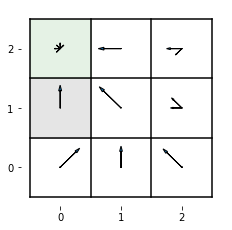

In [7]:
visualizePolicy(gridWidth, gridHeight, toyGoalA, toyTraps, toyPolicyA)

In [8]:
toyGoalB = (2,0)
getToyRewardB = SetupRewardTable(toyTransition, allActions, toyGoalB, toyTraps)
toyRewardB = getToyRewardB()

toyValueB = {state:0 for state in toyRewardB.keys()}

getToyPolicyB = BoltzmannValueIteration(toyTransition, toyRewardB, toyValueB, convergenceThreshold, gamma, beta)
optimalToyValuesB, toyPolicyB = getToyPolicyB()

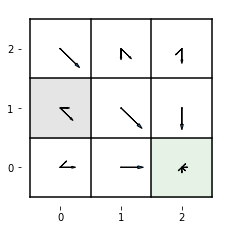

In [9]:
visualizePolicy(gridWidth, gridHeight, toyGoalB, toyTraps, toyPolicyB)

In [10]:
toyPolicies = [toyPolicyA, toyPolicyB]
toyPriors = [.5, .5]
toyTrajectory = [(0,0),(1,1),(0,2)]

In [11]:
toyPolicies

[{(0, 0): {(1, 0): 0.03564342039368153,
   (0, 1): 8.67769139021682e-17,
   (-1, 0): 0.02437515969957158,
   (0, -1): 0.02437515969957158,
   (-1, 1): 0.016339158171942907,
   (1, -1): 0.016339158171942907,
   (1, 1): 0.8665887856913465,
   (-1, -1): 0.016339158171942907},
  (0, 1): {(1, 0): 0.014733064750494889,
   (0, 1): 0.963039014537424,
   (-1, 0): 9.889320251873724e-19,
   (0, -1): 0.00027778558791730415,
   (-1, 1): 9.889320251873724e-19,
   (1, -1): 0.00040620158437839796,
   (1, 1): 0.02154393353978517,
   (-1, -1): 9.889320251873724e-19},
  (0, 2): {(1, 0): 0.005532411233177468,
   (0, 1): 0.24730524962751022,
   (-1, 0): 0.24730524962751022,
   (0, -1): 2.53954489550016e-19,
   (-1, 1): 0.16577366631516696,
   (1, -1): 0.002536090566301129,
   (1, 1): 0.16577366631516696,
   (-1, -1): 0.16577366631516696},
  (1, 0): {(1, 0): 0.01682357352336302,
   (0, 1): 0.8922806917733611,
   (-1, 0): 0.01682356799139129,
   (0, -1): 0.024600844213110262,
   (-1, 1): 4.014736497549751e-1

In [12]:
class PerformGoalInference(object):
    def __init__(self, transitionTable, goalPolicies, goalPriors, stateTrajectory):
        self.transitionTable = transitionTable
        self.goalPolicies  = goalPolicies
        self.goalPriors = goalPriors
        self.stateTrajectory = stateTrajectory

    def __call__(self):
        posterior = self.getSequenceOfStateProbabilities()*np.array(self.goalPriors)        
        row_sums = posterior.sum(axis=1, keepdims=True)
        normalizedPosterior = posterior / row_sums
        return(normalizedPosterior)
        
    def getNextStateProbability(self, state, nextState, policy):
        possibleActionsToNextState = [action for action in self.transitionTable[state] \
                                      if nextState in self.transitionTable[state][action]]

        probNextState = sum([self.transitionTable[state][action][nextState]*policy[state][action] \
                             for action in possibleActionsToNextState])
        return(probNextState)
    
    def getSequenceOfStateProbabilities(self):
        probNextState = [self.goalPriors]
        for t, state in enumerate(self.stateTrajectory[:-1]):
            nextState = self.stateTrajectory[t+1]
            probNextState.append([self.getNextStateProbability(state, nextState, goalPolicy) \
                         for goalPolicy in self.goalPolicies])
        observedStateProbs = np.cumprod(np.array(probNextState), axis=0)
        return(observedStateProbs)


In [13]:
doGoalInference = PerformGoalInference(toyTransition, toyPolicies, toyPriors, toyTrajectory)
toyPosteriors = doGoalInference()

In [16]:
toyPosteriors

array([[0.5       , 0.5       ],
       [0.64353681, 0.35646319],
       [0.99439009, 0.00560991]])